In [ ]:
import os
import PIL
import json
import pickle
import numpy as np
from math import log, exp
# from tqdm import tqdm
from random import shuffle
from PIL import ImageEnhance, ImageFont, ImageDraw
from IPython.display import Image, display
from multiprocessing import Pool
# import cv2
import shutil
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.regularizers import l2
# from tensorflow.keras.preprocessing.image import load_img, img_to_array
# from tensorflow.python.keras.utils.data_utils import Sequence

# tf.keras.backend.clear_session()  # For easy reset of notebook state.

cat_list = ['tops', 'trousers', 'outerwear', 'dresses', 'skirts']

input_shape = (224,224,3)
wt_decay = 5e-4

dims_list = [(7,7),(14,14)]
aspect_ratios = [(1,1), (1,2), (2,1)]

base_folder = '../til2020'
data_folder = base_folder
train_imgs_folder = os.path.join( data_folder, 'train', 'train' )
train_annotations = os.path.join( data_folder, 'train.json' )
val_imgs_folder = os.path.join( data_folder, 'val', 'val' )
val_annotations = os.path.join( data_folder, 'val.json' )

train_pickle = os.path.join( data_folder, 'train.p/train.p' )
val_pickle = os.path.join( data_folder, 'val.p/val.p' )

save_model_folder = os.path.join( base_folder, 'sj' )
load_model_folder = save_model_folder

# Precomputed detections json file for tutorial
model_detections = os.path.join(data_folder, 'detections-7x7-14x14-top100.json')

# importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import patches

In [ ]:
with open(train_annotations, "r") as f:
    data = json.load(f)
    
# images: filename, id 
# annotations: area, iscrowd, id, image_id, category_id, bbox 
# categories: id, name



In [ ]:
categories = data["categories"]
categories = pd.DataFrame(categories)
temp_id = list(categories.to_dict()["id"].values())
temp_name = list(categories.to_dict()["name"].values())
categories = dict(zip(temp_id, temp_name))

In [ ]:
categories

{1: 'tops', 2: 'trousers', 3: 'outerwear', 4: 'dresses', 5: 'skirts'}

In [ ]:
images = data["images"]
images = pd.DataFrame(images)
images.head(5)

,file_name,id
0,10.jpg,10
1,1000.jpg,1000
2,10003.jpg,10003
3,10005.jpg,10005
4,1001.jpg,1001


In [ ]:
train = data["annotations"]
df = pd.DataFrame(train)
df.head(5)

,area,iscrowd,id,image_id,category_id,bbox
0,2304645.0,0,1,10,4,"[704, 620, 1401, 1645]"
1,55769.0,0,2,1000,1,"[321, 332, 217, 257]"
2,17108.0,0,3,10003,2,"[220, 758, 188, 91]"
3,117909.0,0,4,10003,5,"[150, 397, 297, 397]"
4,105925.0,0,5,10003,1,"[85, 207, 475, 223]"


In [ ]:
train = df.merge(images, left_on="image_id", right_on="id")
train = train.rename(columns={"id_x": "id"})
train[["xmin", "ymin", "w", "h"]] = pd.DataFrame(train.bbox.tolist(), index=train.index)
train = train.drop(columns=["id_y",  "bbox"])
train

,area,iscrowd,id,image_id,category_id,file_name,xmin,ymin,w,h
0,2304645.0,0,1,10,4,10.jpg,704.0,620.0,1401.0,1645.0
1,55769.0,0,2,1000,1,1000.jpg,321.0,332.0,217.0,257.0
2,17108.0,0,3,10003,2,10003.jpg,220.0,758.0,188.0,91.0
3,117909.0,0,4,10003,5,10003.jpg,150.0,397.0,297.0,397.0
4,105925.0,0,5,10003,1,10003.jpg,85.0,207.0,475.0,223.0
...,...,...,...,...,...,...,...,...,...,...
13312,59095.0,0,10391,3163,1,3163.jpg,147.0,192.0,223.0,265.0
13313,1420334.0,0,10392,11870,1,11870.jpg,465.0,429.0,1151.0,1234.0
13314,1776670.0,0,10393,10864,1,10864.jpg,431.0,746.0,1493.0,1190.0
13315,116982.0,0,10394,6353,1,6353.jpg,260.0,405.0,402.0,291.0


In [ ]:
def print_image(image, categories, train):    
    fig = plt.figure()

    #add axes to the image
    ax = fig.add_axes([0, 0, 1, 1])
    # read and plot the image
    pimage = plt.imread(os.path.join(train_imgs_folder, image))
    plt.imshow(pimage)

    # iterating over the image for different objects
    for _,row in train[train.file_name == image].iterrows():
        xmin = row.xmin
        print("xmin: ", xmin)
        xmax = row.xmin + row.w
        print("xmax: ", xmax)
        ymin = row.ymin
        print("ymin: ", ymin)
        ymax = row.ymin + row.h
        print("ymax: ", ymax)

        width = row.w
        height = row.h

    # assign different color to different classes of objects
        if row.category_id ==  1:
            edgecolor = "red"
            ax.annotate(categories[1], xy=(xmax-40,ymin+20))
        elif row.category_id == 2:
            edgecolor = "blue"
            ax.annotate(categories[2], xy=(xmax-40,ymin+20))
        elif row.category_id == 3:
            edgecolor = "green"
            ax.annotate(categories[3], xy=(xmax-40,ymin+20))
        elif row.category_id == 4:
            edgecolor = "yellow"
            ax.annotate(categories[4], xy=(xmax-40,ymin+20))
        elif row.category_id == 5:    
            edgecolor = "purple"
            ax.annotate(categories[5], xy=(xmax-40,ymin+20))

    # add bounding boxes to the image
        rect = patches.Rectangle((xmin,ymin), 
                             width, height, 
                             edgecolor = edgecolor, 
                             facecolor = 'none')
        ax.add_patch(rect)


xmin:  704.0
xmax:  2105.0
ymin:  620.0
ymax:  2265.0


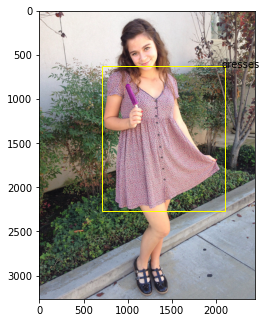

In [ ]:
print_image("10.jpg", categories, train)

<h1>Training prep<h1>

In [ ]:
train

,area,iscrowd,id,image_id,category_id,file_name,xmin,ymin,w,h
0,2304645.0,0,1,10,4,10.jpg,704.0,620.0,1401.0,1645.0
1,55769.0,0,2,1000,1,1000.jpg,321.0,332.0,217.0,257.0
2,17108.0,0,3,10003,2,10003.jpg,220.0,758.0,188.0,91.0
3,117909.0,0,4,10003,5,10003.jpg,150.0,397.0,297.0,397.0
4,105925.0,0,5,10003,1,10003.jpg,85.0,207.0,475.0,223.0
...,...,...,...,...,...,...,...,...,...,...
13312,59095.0,0,10391,3163,1,3163.jpg,147.0,192.0,223.0,265.0
13313,1420334.0,0,10392,11870,1,11870.jpg,465.0,429.0,1151.0,1234.0
13314,1776670.0,0,10393,10864,1,10864.jpg,431.0,746.0,1493.0,1190.0
13315,116982.0,0,10394,6353,1,6353.jpg,260.0,405.0,402.0,291.0


In [ ]:
def transform_xy(file_name, category_id, xmin, ymin, w, h):
    im = PIL.Image.open(os.path.join(train_imgs_folder, file_name))
    width, height = im.size
    xc = round((xmin + w/2) / width, 6)
    yc = round((ymin + h/2) / height, 6)
    wc = round((w / width), 6)
    hc = round((h / height), 6)
    
    return category_id-1, xc, yc, wc, hc

In [ ]:
train["transformations"] = train.apply(lambda x: transform_xy(x["file_name"],x["category_id"], x["xmin"], x["ymin"], x["w"], x["h"]), axis=1)

In [ ]:
train

,area,iscrowd,id,image_id,category_id,file_name,xmin,ymin,w,h,transformations
0,2304645.0,0,1,10,4,10.jpg,704.0,620.0,1401.0,1645.0,"(3, 0.573734, 0.441942, 0.572304, 0.503983)"
1,55769.0,0,2,1000,1,1000.jpg,321.0,332.0,217.0,257.0,"(0, 0.652736, 0.479687, 0.329787, 0.267708)"
2,17108.0,0,3,10003,2,10003.jpg,220.0,758.0,188.0,91.0,"(1, 0.526846, 0.899776, 0.315436, 0.101904)"
3,117909.0,0,4,10003,5,10003.jpg,150.0,397.0,297.0,397.0,"(4, 0.500839, 0.666853, 0.498322, 0.444569)"
4,105925.0,0,5,10003,1,10003.jpg,85.0,207.0,475.0,223.0,"(0, 0.541107, 0.356663, 0.79698, 0.24972)"
...,...,...,...,...,...,...,...,...,...,...,...
13312,59095.0,0,10391,3163,1,3163.jpg,147.0,192.0,223.0,265.0,"(0, 0.359028, 0.338021, 0.309722, 0.276042)"
13313,1420334.0,0,10392,11870,1,11870.jpg,465.0,429.0,1151.0,1234.0,"(0, 0.425041, 0.320466, 0.47018, 0.378064)"
13314,1776670.0,0,10393,10864,1,10864.jpg,431.0,746.0,1493.0,1190.0,"(0, 0.745253, 0.848734, 0.944937, 0.753165)"
13315,116982.0,0,10394,6353,1,6353.jpg,260.0,405.0,402.0,291.0,"(0, 0.960417, 0.860156, 0.8375, 0.454688)"


In [ ]:
path = "YOLO_output"
for photo in os.listdir(train_imgs_folder):
    l = []
    fn = os.path.join(path, "{}txt".format(photo[:-3]))
    for _,row in train[train.file_name == photo].iterrows():
        cat, xc, yc, w, h = row.transformations
        string = "{} {} {} {} {}\n".format(cat, xc, yc, w, h)
        l.append(string)

    with open(fn, "w") as f:
        f.writelines(l)

In [ ]:
train.loc[train.file_name == "25.jpg"]

,area,iscrowd,id,image_id,category_id,file_name,xmin,ymin,w,h,transformations
1209,33383.0,0,1213,25,4,25.jpg,333.0,335.0,133.0,251.0,"(4, 0.749531, 0.575625, 0.249531, 0.31375)"
1210,23805.0,0,1214,25,5,25.jpg,152.0,453.0,115.0,207.0,"(5, 0.393058, 0.695625, 0.21576, 0.25875)"
1211,16366.0,0,1215,25,1,25.jpg,162.0,312.0,98.0,167.0,"(1, 0.395872, 0.494375, 0.183865, 0.20875)"


<h1>Validation prep<h1>

In [ ]:
with open(val_annotations, "r") as f:
    val = json.load(f)
    
# images: filename, id 
# annotations: area, iscrowd, id, image_id, category_id, bbox 
# categories: id, name



In [ ]:
categories = val["categories"]
categories = pd.DataFrame(categories)
temp_id = list(categories.to_dict()["id"].values())
temp_name = list(categories.to_dict()["name"].values())
categories = dict(zip(temp_id, temp_name))
categories

{1: 'tops', 2: 'trousers', 3: 'outerwear', 4: 'dresses', 5: 'skirts'}

In [ ]:
images = val["images"]
images = pd.DataFrame(images)
images.head(5)

,file_name,id
0,1.jpg,1
1,10000.jpg,10000
2,10004.jpg,10004
3,10006.jpg,10006
4,10011.jpg,10011


In [ ]:
valid = val["annotations"]
df = pd.DataFrame(valid)
df.head(5)

,area,iscrowd,id,image_id,category_id,bbox
0,996743.0,0,1,1,4,"[523, 55, 869, 1147]"
1,391795.0,0,2,10000,2,"[182, 2163, 635, 617]"
2,2443350.0,0,3,10000,4,"[70, 16, 1074, 2275]"
3,294168.0,0,4,10004,4,"[552, 564, 357, 824]"
4,748984.0,0,5,10006,4,"[58, 289, 1004, 746]"


In [ ]:
df.size

14748

In [ ]:
valid = df.merge(images, left_on="image_id", right_on="id")
valid = valid.rename(columns={"id_x": "id"})
valid[["xmin", "ymin", "w", "h"]] = pd.DataFrame(valid.bbox.tolist(), index=valid.index)
valid = valid.drop(columns=["id_y",  "bbox"])
valid

,area,iscrowd,id,image_id,category_id,file_name,xmin,ymin,w,h
0,996743.0,0,1,1,4,1.jpg,523.0,55.0,869.0,1147.0
1,391795.0,0,2,10000,2,10000.jpg,182.0,2163.0,635.0,617.0
2,2443350.0,0,3,10000,4,10000.jpg,70.0,16.0,1074.0,2275.0
3,294168.0,0,4,10004,4,10004.jpg,552.0,564.0,357.0,824.0
4,748984.0,0,5,10006,4,10006.jpg,58.0,289.0,1004.0,746.0
...,...,...,...,...,...,...,...,...,...,...
2453,351393.0,0,2454,18477,3,18477.jpg,17.0,310.0,609.0,577.0
2454,97352.0,0,2455,2037,2,2037.jpg,175.0,766.0,344.0,283.0
2455,164864.0,0,2456,2037,1,2037.jpg,192.0,408.0,448.0,368.0
2456,38608.0,0,2457,17983,2,17983.jpg,218.0,314.0,152.0,254.0


In [ ]:
def transform_xy(file_name, category_id, xmin, ymin, w, h):
    im = PIL.Image.open(os.path.join(val_imgs_folder, file_name))
    width, height = im.size
    xc = round((xmin + w/2) / width, 6)
    yc = round((ymin + h/2) / height, 6)
    wc = round((w / width), 6)
    hc = round((h / height), 6)
    
    return category_id-1, xc, yc, wc, hc

In [ ]:
valid["transformations"] = valid.apply(lambda x: transform_xy(x["file_name"],x["category_id"], x["xmin"], x["ymin"], x["w"], x["h"]), axis=1)

In [ ]:
valid

,area,iscrowd,id,image_id,category_id,file_name,xmin,ymin,w,h,transformations
0,996743.0,0,1,1,4,1.jpg,523.0,55.0,869.0,1147.0,"(3, 0.492541, 0.323302, 0.447016, 0.590021)"
1,391795.0,0,2,10000,2,10000.jpg,182.0,2163.0,635.0,617.0,"(1, 0.430603, 0.889029, 0.547414, 0.221942)"
2,2443350.0,0,3,10000,4,10000.jpg,70.0,16.0,1074.0,2275.0,"(3, 0.523276, 0.414928, 0.925862, 0.818345)"
3,294168.0,0,4,10004,4,10004.jpg,552.0,564.0,357.0,824.0,"(3, 0.475586, 0.476562, 0.232422, 0.402344)"
4,748984.0,0,5,10006,4,10006.jpg,58.0,289.0,1004.0,746.0,"(3, 0.459393, 0.54085, 0.823626, 0.609477)"
...,...,...,...,...,...,...,...,...,...,...,...
2453,351393.0,0,2454,18477,3,18477.jpg,17.0,310.0,609.0,577.0,"(2, 0.386418, 0.532947, 0.731971, 0.513802)"
2454,97352.0,0,2455,2037,2,2037.jpg,175.0,766.0,344.0,283.0,"(1, 0.542188, 0.798856, 0.5375, 0.24912)"
2455,164864.0,0,2456,2037,1,2037.jpg,192.0,408.0,448.0,368.0,"(0, 0.65, 0.521127, 0.7, 0.323944)"
2456,38608.0,0,2457,17983,2,17983.jpg,218.0,314.0,152.0,254.0,"(1, 0.480392, 0.720588, 0.248366, 0.415033)"


In [ ]:
path = "val_texts"
for photo in os.listdir(val_imgs_folder):
    l = []
    fn = os.path.join(path, "{}txt".format(photo[:-3]))
    for _,row in valid[valid.file_name == photo].iterrows():
        cat, xc, yc, w, h = row.transformations
        string = "{} {} {} {} {}\n".format(cat, xc, yc, w, h)
        l.append(string)

    with open(fn, "w") as f:
        f.writelines(l)

In [ ]:
%cd ..

/Users/seanjin/Downloads


In [ ]:
!scp -i visionimpossible.pem YOLO/val_texts.zip ubuntu@ec2-3-16-149-196.us-east-2.compute.amazonaws.com://home/ubuntu/darknet/build/darknet/x64/data/valid

val_texts.zip                                 100%  342KB 135.9KB/s   00:02    


<h1>train.txt/ valid.txt<h1>

In [ ]:
path = "/home/ec2-user/darknet/build/darknet/x64/data/"
folder = os.path.join(path, "obj")
folder

'/home/ec2-user/darknet/build/darknet/x64/data/obj'

In [ ]:
%cd ~/Downloads/YOLO

/Users/seanjin/Downloads/YOLO


In [ ]:
l = []
for files in os.listdir(val_imgs_folder):
    if not files.endswith('txt'):
        text = "/home/ubuntu/darknet/build/darknet/x64/data/valid/{}\n".format(files)
        l.append(text)

with open("valid.txt", "w") as f:
    f.writelines(l)

In [ ]:
len(l)

1474

In [ ]:
%cd .. 

/Users/seanjin/Downloads


In [ ]:
!scp -i visionimpossible.pem YOLO/valid.txt ubuntu@ec2-3-16-149-196.us-east-2.compute.amazonaws.com://home/ubuntu/darknet/build/darknet/x64/data

valid.txt                                     100%   85KB  72.7KB/s   00:01    


<h1>Checking against pycoco<h1>

In [ ]:
%pip install git+https://github.com/jinmingteo/cocoapi.git#subdirectory=PythonAPI

  Cloning https://github.com/jinmingteo/cocoapi.git to /private/var/folders/sb/gy4zc2sx4ks_22lqsnk_7h540000gn/T/pip-req-build-wohuwooj
  Running command git clone -q https://github.com/jinmingteo/cocoapi.git /private/var/folders/sb/gy4zc2sx4ks_22lqsnk_7h540000gn/T/pip-req-build-wohuwooj
     |████████████████████████████████| 1.9 MB 5.5 MB/s eta 0:00:01
  ERROR: Command errored out with exit status 1:
   command: /usr/local/opt/python/bin/python3.7 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/sb/gy4zc2sx4ks_22lqsnk_7h540000gn/T/pip-req-build-wohuwooj/PythonAPI/setup.py'"'"'; __file__='"'"'/private/var/folders/sb/gy4zc2sx4ks_22lqsnk_7h540000gn/T/pip-req-build-wohuwooj/PythonAPI/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /private/var/folders/sb/gy4zc2sx4ks_22lqsnk_7h540000gn/T/pip-wheel-sas5vu21
       cwd: 

In [ ]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

In [ ]:
# Get evaluation score against validation set
coco_gt = COCO(val_annotations)
coco_dt = coco_gt.loadRes('results/submission.json')
cocoEval = COCOeval(cocoGt=coco_gt, cocoDt=coco_dt, iouType='bbox')
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.15s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.12s).
Accumulating evaluation results...
DONE (t=0.56s).
 Average Precision  (AP) @[ IoU=0.20:0.50 | area=   all | maxDets=100 ] = 0.154
 Average Precision  (AP) @[ IoU=0.20      | area=   all | maxDets=100 ] = 0.387
 Average Precision  (AP) @[ IoU=0.30      | area=   all | maxDets=100 ] = 0.191
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.063
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.013


<h1>Check submission.json<h1>

In [ ]:
%cd YOLO

[Errno 2] No such file or directory: 'YOLO'
/Users/seanjin/Downloads/YOLO


In [ ]:
with open("../test_result4_raw.json", "r") as f:
    sub = json.load(f)

In [ ]:
len(sub[0]["objects"])

1

In [ ]:
sub[0]

{'frame_id': 1,
 'filename': '/home/ubuntu/darknet/build/darknet/x64/data/test/63.jpg',
 'objects': [{'class_id': 3,
   'name': 'dresses',
   'relative_coordinates': {'center_x': 0.555027,
    'center_y': 0.499578,
    'width': 0.708079,
    'height': 1.271478},
   'confidence': 0.589685}]}

In [ ]:
pred = pd.DataFrame(sub)

In [ ]:
l = []
path = "../test"
for i in range(len(sub)):
    imgid = int(sub[i]["filename"].split("/")[-1][:-4])
    im = PIL.Image.open(os.path.join(path, sub[i]["filename"].split("/")[-1]))
    width, height = im.size
    objects = sub[i]["objects"]
    for o in objects:
        cat_id = o["class_id"] + 1
        xmin = round((o["relative_coordinates"]["center_x"] - o["relative_coordinates"]["width"]/2) * width, 6)
        ymin = round((o["relative_coordinates"]["center_y"] - o["relative_coordinates"]["height"]/2) * height, 6)
        w = o["relative_coordinates"]["width"] * width
        h = o["relative_coordinates"]["height"] * height
        score = o["confidence"]
        l.append({"image_id": imgid, "category_id":cat_id, "bbox": [xmin, ymin, w, h], "score": score})
len(l)

/usr/local/lib/python3.7/site-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (99272481 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


3949

In [ ]:
l[:5]

[{'image_id': 63,
  'category_id': 4,
  'bbox': [123.00435, -83.330532, 433.344348, 778.144536],
  'score': 0.589685},
 {'image_id': 6372,
  'category_id': 4,
  'bbox': [886.426057, 825.015888, 1327.052678, 2204.3434049999996],
  'score': 0.696582},
 {'image_id': 6372,
  'category_id': 3,
  'bbox': [910.762229, 822.947907, 1356.995514, 1052.128122],
  'score': 0.49936},
 {'image_id': 10453,
  'category_id': 5,
  'bbox': [674.716311, 1631.342256, 1007.443818, 1422.4138560000001],
  'score': 0.410377},
 {'image_id': 10453,
  'category_id': 1,
  'bbox': [374.523507, 647.871024, 1578.5304299999998, 1149.850272],
  'score': 0.500471}]

In [ ]:
c = 0
for i in sub:
    c += len(i["objects"])
c

4316

In [ ]:
with open('../submission_finaltrainweights.json', 'w') as f:
    json.dump(l, f)

In [ ]:
with open('../submission_5kweights.json', 'r') as f:
    det = json.load(f)

In [ ]:
pred = pd.DataFrame(det)

In [ ]:
pred[pred.category_id==0]

,image_id,category_id,bbox,score


In [ ]:
pred["file_name"] = pred['image_id'].astype(str) + ".jpg"
pred[["xmin", "ymin", "w", "h"]] = pd.DataFrame(pred.bbox.tolist(), index=pred.index)
pred = pred.drop(columns=["bbox"])
pred.sample(5)

,image_id,category_id,score,file_name,xmin,ymin,w,h
2989,17780,4,0.497336,17780.jpg,1103.107968,599.195328,990.945504,1661.943936
3640,3605,4,0.931785,3605.jpg,33.435000,396.616500,222.904000,384.311000
3016,7163,2,0.296377,7163.jpg,347.321700,510.186800,147.641400,58.084000
2833,5560,4,0.965740,5560.jpg,308.769736,387.169024,442.780624,920.602848
2821,4124,5,0.309007,4124.jpg,397.217280,125.050240,332.595840,729.140480


In [ ]:
pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4316 entries, 0 to 4315
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image_id     4316 non-null   int64  
 1   category_id  4316 non-null   int64  
 2   score        4316 non-null   float64
 3   file_name    4316 non-null   object 
 4   xmin         4316 non-null   float64
 5   ymin         4316 non-null   float64
 6   w            4316 non-null   float64
 7   h            4316 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 269.9+ KB


In [ ]:
data_folder = '/Downloads/YOLO'
path = '../test'

def visualisesub(image, categories, pred):    
#     print(image)
    fig = plt.figure()

    #add axes to the image
    ax = fig.add_axes([0, 0, 1, 1])
    # read and plot the image
    pimage = plt.imread(os.path.join(path, image))
    plt.title(image)
    plt.imshow(pimage)
    # iterating over the image for different objects
    for _,row in pred[pred.file_name == image].iterrows():
        xmin = row.xmin
        print("xmin: ", xmin)
        xmax = row.xmin + row.w
        print("xmax: ", xmax)
        ymin = row.ymin
        print("ymin: ", ymin)
        ymax = row.ymin + row.h
        print("ymax: ", ymax)

        width = row.w
        height = row.h

    # assign different color to different classes of objects
        if row.category_id ==  1:
            edgecolor = "red"
            ax.annotate(categories[1], xy=(xmax-40,ymin+20))
        elif row.category_id == 2:
            edgecolor = "blue"
            ax.annotate(categories[2], xy=(xmax-40,ymin+20))
        elif row.category_id == 3:
            edgecolor = "green"
            ax.annotate(categories[3], xy=(xmax-40,ymin+20))
        elif row.category_id == 4:
            edgecolor = "yellow"
            ax.annotate(categories[4], xy=(xmax-40,ymin+20))
        elif row.category_id == 5:    
            edgecolor = "purple"
            ax.annotate(categories[5], xy=(xmax-40,ymin+20))

    # add bounding boxes to the image
        rect = patches.Rectangle((xmin,ymin), 
                             width, height, 
                             edgecolor = edgecolor, 
                             facecolor = 'none')
        ax.add_patch(rect)
    plt.show(block=False)

In [ ]:
cat_list = ['tops', 'trousers', 'outerwear', 'dresses', 'skirts']
categories = {k+1: v for k, v in enumerate(cat_list)}

In [ ]:
categories

{1: 'tops', 2: 'trousers', 3: 'outerwear', 4: 'dresses', 5: 'skirts'}

In [ ]:
pred[pred.category_id==3]

,image_id,category_id,score,file_name,xmin,ymin,w,h
6,2882,3,0.471478,2882.jpg,1106.640432,1118.468352,682.477920,998.157312
12,8363,3,0.484196,8363.jpg,131.432750,150.690771,248.746500,244.141590
19,17894,3,0.918891,17894.jpg,805.540560,815.142528,539.830368,485.294976
22,9531,3,0.645783,9531.jpg,788.300100,435.946500,781.166400,581.481000
26,14351,3,0.747296,14351.jpg,332.067528,731.488512,1303.821936,1002.968448
...,...,...,...,...,...,...,...,...
4273,9919,3,0.342647,9919.jpg,314.292192,526.869576,933.220032,1722.469104
4281,2680,3,0.349302,2680.jpg,30.544353,533.284560,853.827870,340.167569
4286,8391,3,0.767398,8391.jpg,415.165800,544.498200,487.542000,383.976000
4292,16013,3,0.557223,16013.jpg,984.160671,487.644564,715.326666,832.316580


xmin:  465.216003
xmax:  712.448541
ymin:  733.17899
ymax:  1101.49215
xmin:  471.46959
xmax:  717.4181699999999
ymin:  395.95069
ymax:  1142.89031
xmin:  297.894717
xmax:  530.749899
ymin:  700.57809
ymax:  1311.00163
xmin:  274.708602
xmax:  540.5696820000001
ymin:  282.2794
ymax:  712.0555999999999
xmin:  531.594189
xmax:  740.643579
ymin:  430.032145
ymax:  664.440015


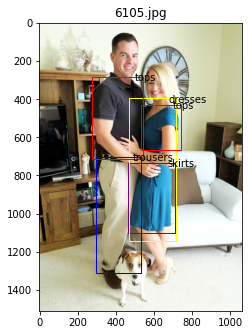

In [ ]:
visualisesub("6105.jpg", categories, pred)

<h1>Prepare annotations for Interim images for testing<h1>

In [ ]:
testids= [i[:-4] for i in os.listdir("../til2020/CV_interim_images")]

In [ ]:
trainids = [i for i in os.listdir("../til2020/newlabels/trainv2") if i.endswith("txt")]
len(trainids)

9054

In [ ]:
valids = [i for i in os.listdir("../til2020/newlabels/valv2") if i.endswith("txt")]
len(valids)

1474

In [ ]:
allids = valids + trainids

In [ ]:
txttocopy = [i for i in allids if i[:-4] in interimids]

In [ ]:
len(txttocopy)

1000

In [ ]:
images = []
for i in txttocopy:
    images.append({"file_name": i[:-4] + ".jpg", "id": i[:-4]})
len(images)

1000

In [ ]:
categories = [{'id': 1, 'name': 'tops'},
 {'id': 2, 'name': 'trousers'},
 {'id': 3, 'name': 'outerwear'},
 {'id': 4, 'name': 'dresses'},
 {'id': 5, 'name': 'skirts'}]

In [ ]:
categories

[{'id': 1, 'name': 'tops'},
 {'id': 2, 'name': 'trousers'},
 {'id': 3, 'name': 'outerwear'},
 {'id': 4, 'name': 'dresses'},
 {'id': 5, 'name': 'skirts'}]

In [ ]:
pred["id"] = pred["image_id"]

In [ ]:
pred

,image_id,category_id,bbox,score,id
0,16705,3,"[473.6905, 273.5715, 278.96500000000003, 470.3...",0.562085,16705
1,16705,2,"[543.137, 748.65975, 188.07, 298.0185]",0.467289,16705
2,7941,4,"[316.270584, 399.541344, 1059.927696, 2174.85216]",0.671948,7941
3,7941,2,"[584.799048, 2369.553024, 717.364368, 508.7727...",0.258800,7941
4,11391,4,"[715.206456, 634.436736, 1082.287728, 2004.069...",0.746061,11391
...,...,...,...,...,...
1593,12655,5,"[238.37248, 245.46272, 144.47744, 281.26528]",0.456034,12655
1594,12655,1,"[253.6832, 108.38784, 145.47584, 155.97696]",0.747104,12655
1595,16278,4,"[157.11024, 285.84576, 455.30976, 952.99840000...",0.659492,16278
1596,18526,4,"[1139.4576, 458.6352, 491.0304, 920.1312]",0.790874,18526


In [ ]:
annotations = pred.to_dict(orient='records')

In [ ]:
test = {"annotations":annotations, "images": images, "categories":categories}

In [ ]:
print(test["annotations"][0])
print(test["images"][0])

{'image_id': 16705, 'category_id': 3, 'bbox': [473.6905, 273.5715, 278.96500000000003, 470.31899999999996], 'score': 0.562085, 'id': 16705}
{'file_name': '1293.jpg', 'id': '1293'}


In [ ]:
with open("interim_test.json", "w") as f:
    json.dump(test, f)